In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import os

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bevan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


In [4]:
df = pd.read_csv(r'dataset\jobs_dataset_with_features.csv')

In [5]:
import swifter

df['cleaned_resume'] = df['Features'].swifter.apply(preprocess_text)


c:\Users\bevan\.conda\envs\Resume\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply: 100%|██████████| 1615940/1615940 [15:18<00:00, 1759.85it/s]


In [6]:

# Encode target labels
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Role'])
y = to_categorical(df['Category_encoded'])


In [7]:
# Tokenization and Padding
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100

In [10]:
sequence_generator = tokenizer.texts_to_sequences_generator(df['cleaned_resume'])
sequences = []
for seq in sequence_generator:
    sequences.append(seq)

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [12]:
df_sample = df.sample(n=50000, random_state=42)
tokenizer.fit_on_texts(df_sample['cleaned_resume'])

sequence_generator = tokenizer.texts_to_sequences_generator(df_sample['cleaned_resume'])
sequences = [seq for seq in sequence_generator]

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [13]:
import tensorflow as tf

def gen():
    for text in df['cleaned_resume']:
        yield tokenizer.texts_to_sequences([text])[0]

dataset = tf.data.Dataset.from_generator(
    gen,
    output_types=tf.int32,
    output_shapes=(None,)
)

padded_dataset = dataset.padded_batch(batch_size=32, padded_shapes=[MAX_SEQUENCE_LENGTH])


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [14]:
MAX_SEQUENCE_LENGTH = 100


In [17]:
df_sample = df.sample(n=50000, random_state=42)

# Recreate X and y from the same sample
tokenizer.fit_on_texts(df_sample['cleaned_resume'])
sequences = tokenizer.texts_to_sequences(df_sample['cleaned_resume'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

label_encoder = LabelEncoder()
df_sample['Category_encoded'] = label_encoder.fit_transform(df_sample['Role'])
y = to_categorical(df_sample['Category_encoded'])

# Now X and y are both length 50000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
# Load GloVe embeddings
import os

def load_glove_embeddings(glove_path='glove.6B.100d.txt'):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


    # Prepare embedding matrix
def create_embedding_matrix(word_index, embeddings_index, max_num_words, embedding_dim):
    embedding_matrix = np.zeros((max_num_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_num_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


path_of_file = 'C:/Users/bevan/OneDrive/Desktop/fyp_project/Resume_catalyst/glove.6B/glove.6B.100d.txt'

# Use GloVe embeddings
if not os.path.exists(path_of_file):
    print("Please download GloVe embeddings from: https://nlp.stanford.edu/data/glove.6B.zip")
    raise SystemExit

embeddings_index = load_glove_embeddings(path_of_file)
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embeddings_index, MAX_NUM_WORDS, EMBEDDING_DIM)


# Check GloVe coverage
num_known_words = sum(1 for word in tokenizer.word_index if word in embeddings_index)
print(f"Known words in GloVe: {num_known_words} / {len(tokenizer.word_index)}")




Known words in GloVe: 1637 / 1740


In [19]:
def create_model():
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()


c:\Users\bevan\.conda\envs\Resume\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['Category_encoded']), y=df['Category_encoded'])
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [22]:

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 147s 131ms/step - accuracy: 0.7901 - loss: 0.7040 - val_accuracy: 0.9958 - val_loss: 0.0111
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 159s 142ms/step - accuracy: 0.8968 - loss: 0.3390 - val_accuracy: 0.9990 - val_loss: 0.0060
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 171s 152ms/step - accuracy: 0.9310 - loss: 0.2299 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 158s 141ms/step - accuracy: 0.9434 - loss: 0.1818 - val_accuracy: 1.0000 - val_loss: 2.9460e-04
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 164s 146ms/step - accuracy: 0.9506 - loss: 0.1567 - val_accuracy: 1.0000 - val_loss: 5.4460e-05


In [23]:

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step
                                          precision    recall  f1-score   support

                           API Developer       1.00      1.00      1.00        23
                 Accessibility Developer       1.00      1.00      1.00        20
                       Account Executive       1.00      1.00      1.00        46
                         Account Manager       1.00      1.00      1.00        20
                      Account Strategist       1.00      1.00      1.00        23
                   Accounting Controller       1.00      1.00      1.00        22
                      Accounting Manager       1.00      1.00      1.00        22
           Acute Care Nurse Practitioner       1.00      1.00      1.00        24
                     Addiction Counselor       1.00      1.00      1.00        22
                Administrative Assistant       1.00      1.00      1.00        26
              Administrative Coordinator       1.00   

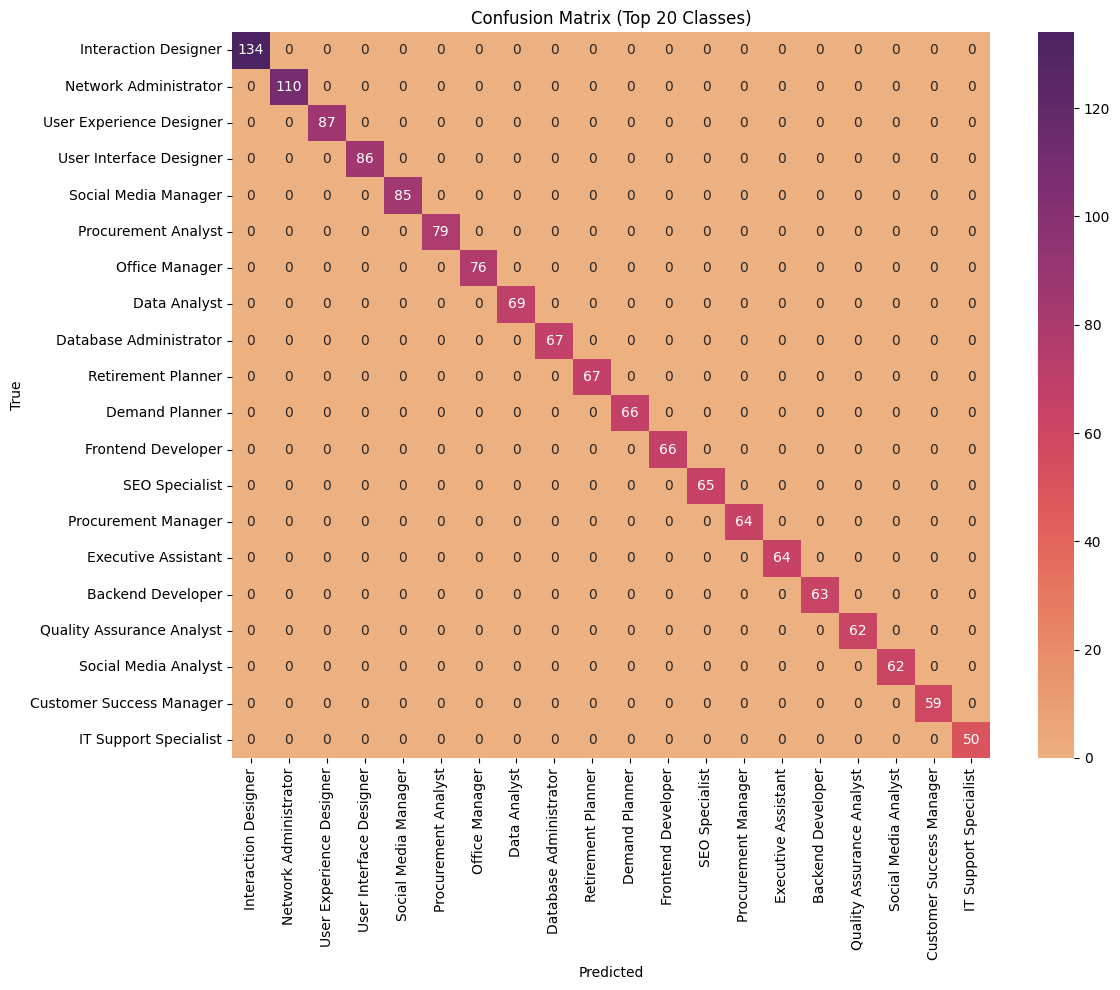

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter

# Limit to top N frequent classes (e.g., top 20)
N = 20
top_classes = [label for label, _ in Counter(y_true_classes).most_common(N)]

# Filter indices for top classes only
top_indices = [i for i, label in enumerate(y_true_classes) if label in top_classes]
filtered_true = [y_true_classes[i] for i in top_indices]
filtered_pred = [y_pred_classes[i] for i in top_indices]

# Build confusion matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels=top_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.inverse_transform(top_classes),
            yticklabels=label_encoder.inverse_transform(top_classes),
            cmap='flare')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 20 Classes)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Example: Get overall average scores
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [28]:
from sklearn.metrics import accuracy_score

# Assuming you've already predicted
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step
Accuracy: 1.0000


In [29]:
def cleanResume(txt):
    import re
    cleanText = re.sub(r'http\S+', ' ', txt)
    cleanText = re.sub(r'RT|cc', ' ', cleanText)
    cleanText = re.sub(r'#\S+', ' ', cleanText)
    cleanText = re.sub(r'@\S+', ' ', cleanText)
    cleanText = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub(r'\s+', ' ', cleanText)
    return cleanText.strip()


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def job_recommendation_rnn(resume_text):
    cleaned_text = cleanResume(resume_text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    
    prediction = model.predict(padded_seq)
    predicted_index = np.argmax(prediction, axis=1)[0]
    predicted_category = label_encoder.inverse_transform([predicted_index])[0]
    return predicted_category


In [31]:
resume_file = """Objective:
        A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to leverage design skills in a dynamic and collaborative environment.

        Education:
        - Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
        - Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

        Skills:
        - Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
        - Strong understanding of typography, layout, and color theory
        - Experience in both print and digital design
        - Ability to conceptualize and execute design projects from concept to completion
        - Excellent attention to detail and time management skills

        Experience:
        Graphic Designer | XYZ Design Studio
        - Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
        - Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
        - Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

        Freelance Designer
        - Designed logos, branding materials, and website layouts for small businesses and startups
        - Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
        - Established and maintained strong client relationships through clear communication and exceptional service

        Projects:
        - Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in a 30% increase in brand recognition
        - Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a successful launch and positive customer feedback

        Certifications:
        - Adobe Certified Expert (ACE) in Adobe Illustrator
        - Responsive Web Design Certification from Udemy

        Languages:
        - English (Native)
        - Spanish (Intermediate)
"""

predicted_job = job_recommendation_rnn(resume_file)
print(f"Predicted Job Category: {predicted_job}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted Job Category: Art Curator


In [33]:
# Example Usage
resume_file = """Objective:
Dedicated and results-oriented Banking professional with a strong background in financial analysis and customer service seeking opportunities to contribute to a reputable financial institution. Eager to leverage expertise in risk management, investment strategies, and relationship building to drive business growth and client satisfaction.

Education:
- Bachelor of Business Administration in Finance, XYZ University, GPA: 3.8/4.0
- Certified Financial Analyst (CFA) Level I Candidate

Skills:
- Proficient in financial modeling and analysis using Excel, Bloomberg Terminal, and other financial software
- Extensive knowledge of banking products and services, including loans, mortgages, and investment products
- Strong understanding of regulatory compliance and risk management practices in the banking industry
- Excellent communication and interpersonal skills, with a focus on building rapport with clients and colleagues
- Ability to work efficiently under pressure and adapt to changing market conditions

Experience:
Financial Analyst | ABC Bank
- Conducted financial analysis and risk assessment for corporate clients, including credit analysis, financial statement analysis, and cash flow modeling
- Developed customized financial solutions to meet clients' needs and objectives, resulting in increased revenue and client retention
- Collaborated with cross-functional teams to identify new business opportunities and optimize existing processes

Customer Service Representative | DEF Bank
- Provided exceptional customer service to bank clients, addressing inquiries, resolving issues, and promoting banking products and services
- Processed transactions accurately and efficiently, including deposits, withdrawals, and account transfers
- Educated customers on various banking products and services, helping them make informed financial decisions

Internship | GHI Investments
- Assisted portfolio managers with investment research and analysis, including industry and company-specific research, financial modeling, and performance analysis
- Prepared investment presentations and reports for clients, highlighting investment opportunities and performance metrics
- Conducted market research and analysis to identify trends and opportunities in the financial markets

Certifications:
- Certified Financial Planner (CFP)
- Series 7 and Series 63 Securities Licenses
Languages:
- English (Native)
- Spanish (Proficient)

"""

predicted_job = job_recommendation_rnn(resume_file)
print(f"Predicted Job Category: {predicted_job}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Job Category: Investment Analyst


In [ ]:
import pickle

with open('rf_classifier_recommendation.pkl', 'wb') as file:
    pickle.dump(model, file)
